In [2]:
!git clone https://github.com/siapai/tuft-dental-segmentation.git temp
!mv temp/segmentation .
!rm -drf temp

Cloning into 'temp'...
remote: Enumerating objects: 549, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 549 (delta 50), reused 180 (delta 29), pack-reused 344
Receiving objects: 100% (549/549), 76.85 MiB | 34.76 MiB/s, done.
Resolving deltas: 100% (57/57), done.
mv: cannot move 'temp/segmentation' to './segmentation': Directory not empty


In [3]:
!pip install -q albumentations
# Install Albumentations, a library for image augmentation, a common technique used in deep learning for computer vision tasks.

!pip install -q torchmetrics
# Install TorchMetrics, a package that provides a collection of metrics for evaluating the performance of PyTorch models.

!pip install -q pretrainedmodels
# Install Pretrained Models, a package that provides pre-trained models for various deep learning architectures.

!pip install -q pytorch-lightning
# Install PyTorch Lightning, a high-level interface for PyTorch that makes it easier to build and train deep learning models.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 7.4 MB/s eta 0:00:00


In [4]:
#Mount google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

# Ensure the destination directory exists
os.makedirs('data', exist_ok=True)

# Unzip the file
!unzip /content/drive/MyDrive/Dataset_TUFT_Dental/Radiographs.zip -d data/
!unzip /content/drive/MyDrive/Dataset_TUFT_Dental/Segmentation.zip -d data/

Archive:  /content/drive/MyDrive/Dataset_TUFT_Dental/Radiographs.zip
   creating: data/Radiographs/
  inflating: data/Radiographs/1.JPG  
  inflating: data/Radiographs/100.JPG  
  inflating: data/Radiographs/1000.JPG  
  inflating: data/Radiographs/1001.JPG  
  inflating: data/Radiographs/1002.JPG  
  inflating: data/Radiographs/1004.JPG  
  inflating: data/Radiographs/1007.JPG  
  inflating: data/Radiographs/1008.JPG  
  inflating: data/Radiographs/1009.JPG  
  inflating: data/Radiographs/101.JPG  
  inflating: data/Radiographs/1010.JPG  
  inflating: data/Radiographs/1011.JPG  
  inflating: data/Radiographs/1012.JPG  
  inflating: data/Radiographs/1013.JPG  
  inflating: data/Radiographs/1014.JPG  
  inflating: data/Radiographs/1015.JPG  
  inflating: data/Radiographs/1016.JPG  
  inflating: data/Radiographs/1017.JPG  
  inflating: data/Radiographs/1018.JPG  
  inflating: data/Radiographs/102.JPG  
  inflating: data/Radiographs/1020.JPG  
  inflating: data/Radiographs/1021.JPG  
  in

In [6]:
import torch
import torchvision
import albumentations as A
!cp /content/drive/MyDrive/Dataset_TUFT_Dental/data_split.json

cp: missing destination file operand after '/content/drive/MyDrive/Dataset_TUFT_Dental/data_split.json'
Try 'cp --help' for more information.


In [7]:
# Function: Define a composition of augmentations for training data
# This function defines a set of augmentations to be applied to the training data,
# including geometric transforms, color and contrast adjustments, blur and noise,
# distortions, and other effects.

import cv2
from albumentations.pytorch import ToTensorV2

safe_transforms = A.Compose([
    # Geometric Transforms
    A.Rotate(limit=3, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=3, p=0.5),
    A.PadIfNeeded(min_height=640, min_width=1280, always_apply=True, border_mode=cv2.BORDER_CONSTANT),
    A.RandomResizedCrop(height=640, width=1280, scale=(0.9, 1.0), p=0.5),  # Safe Cropping with 32 multiples
    A.Resize(height=256, width=512),

    # Color and Contrast Adjustments
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.5),

    # Blur and Noise
    A.GaussianBlur(blur_limit=(3, 5), p=0.5),
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.5),

    # Distortions
    A.ElasticTransform(alpha=0.1, sigma=10, alpha_affine=10, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5),
    A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.5),

    # Other Effects
    A.CLAHE(clip_limit=1.0, p=0.5),
    A.Sharpen(alpha=(0.1, 0.3), lightness=(0.5, 1.0), p=0.5),
    A.Emboss(alpha=(0.1, 0.3), strength=(0.5, 1.0), p=0.5),
    A.MotionBlur(blur_limit=(3, 5), p=0.5),
    A.RandomGamma(gamma_limit=(90, 110), p=0.5),

    # Flips
    A.HorizontalFlip(p=0.5),

    # Normalization and Conversion to Tensor
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])


# Function: Define a composition of augmentations for validation data
# This function defines a set of augmentations to be applied to the validation data,
# including resizing, normalization, and conversion to tensor.
val_transform = A.Compose([
    A.Resize(height=256, width=512),  # Resize to 256x512
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),  # Normalize image to 0-1 range
    ToTensorV2()
])

In [8]:
import json
from torch.utils.data import Dataset
import cv2
import numpy as np

# Function: Define a custom dataset class for dental images and masks
# This class inherits from PyTorch's Dataset class and provides methods for loading and preprocessing dental images and masks.
class DentalDataset(Dataset):
    def __init__(self, data_path: str, split: str, transform=None):
        # Function: Initialize the dataset with a data path, split, and optional transform
        # This function loads the data from a JSON file, extracts the images and masks for the specified split, and stores the transform (if provided).
        with open(data_path, 'r') as f:
            self.data = json.load(f)

        self.images = self.data[split]
        self.transform = transform

    def __len__(self):
        # Function: Return the number of samples in the dataset
        # This function returns the length of the images list, which represents the number of samples in the dataset.
        return len(self.images)

    def __getitem__(self, idx):
        # Function: Return a sample from the dataset at the specified index
        # This function loads an image and its corresponding mask, preprocesses the mask, applies the transform (if provided), and returns the preprocessed image and mask.
        img_path = self.images[idx]['image']
        mask_path = self.images[idx]['mask']

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = self.preprocess_mask(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].permute(2, 0, 1)

        return image, mask

    def preprocess_mask(self, mask):
        # Function: Preprocess a mask by thresholding and adding a channel dimension
        # This function applies a binary threshold to the mask to ensure it only contains 0 and 1 values, and then adds a channel dimension to the mask.
        _, binary_mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
        binary_mask = np.expand_dims(binary_mask, axis=-1)  # Add channel dimension
        return binary_mask

In [9]:
# Function: Create a training dataset instance
# This function creates an instance of the DentalDataset class for the training data,
# specifying the data path, split, and transformation to be applied.
train_dataset = DentalDataset(
    data_path='/content/drive/MyDrive/Dataset_TUFT_Dental/data_split.json',
    split='train',
    transform=safe_transforms
)

# Function: Create a validation dataset instance
# This function creates an instance of the DentalDataset class for the validation data,
# specifying the data path, split, and transformation to be applied.
valid_dataset = DentalDataset(
    data_path='/content/drive/MyDrive/Dataset_TUFT_Dental/data_split.json',
    split='valid',
    transform=val_transform
)

# Function: Create a testing dataset instance
# This function creates an instance of the DentalDataset class for the testing data,
# specifying the data path, split, and transformation to be applied.
test_dataset = DentalDataset(
    data_path='/content/drive/MyDrive/Dataset_TUFT_Dental/data_split.json',
    split='test',
    transform=val_transform
)

# Function: Print the lengths of the train, validation, and test datasets
# This function prints the number of samples in each dataset using the __len__ method of the DentalDataset class.
print(f'[INFO] Length of train dataset: {len(train_dataset)}')
print(f'[INFO] Length of valid dataset: {len(valid_dataset)}')
print(f'[INFO] Length of test dataset: {len(test_dataset)}')

[INFO] Length of train dataset: 700
[INFO] Length of valid dataset: 150
[INFO] Length of test dataset: 150


In [10]:
# Function: Get the first sample from the training dataset
# This function retrieves the first sample from the training dataset, which consists of an image and its corresponding mask.
img, msk = train_dataset[0]

# Function: Print the shapes of the image and mask
# This function prints the shapes of the image and mask, which represent their dimensions.
(img.shape, msk.shape)

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

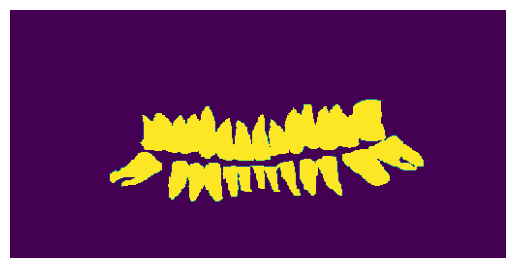

In [11]:
# Function: Import Matplotlib Library
import matplotlib.pyplot as plt

# Function: Display Mask Image
plt.imshow(msk.permute(1, 2, -3))
plt.axis(False)
plt.show()

In [12]:
# Function: Import Necessary Libraries and Modules
import os
from torch.utils.data import DataLoader

# Function: Set Number of Workers
NUM_WORKERS = os.cpu_count()
print(f'Number of Workers: {NUM_WORKERS}')

# Function: Set Batch Size
BATCH_SIZE = 32

# Function: Create Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Number of Workers: 12


In [13]:
# Function: Import Necessary Libraries
import random
import matplotlib.pyplot as plt

# Function: Visualize a Batch of Images and Masks
def visualize_batch(dataloader, num_images=2):
    # Get a batch of images and masks from the dataloader
    images, masks = next(iter(dataloader))

    # Select a random subset of images and masks to visualize
    random_indices = random.sample(range(len(images)), num_images)

    # Create a figure with subplots to display the images and masks
    fig, axes = plt.subplots(num_images, 2, figsize=(16, 4 * num_images))

    # Loop through the selected images and masks
    for i, idx in enumerate(random_indices):
        # Extract the current image and mask
        image = images[i].squeeze(0).permute(1, 2, 0)
        mask = masks[i].squeeze(0)

        # Display the image and mask side by side
        axes[i, 0].imshow(image, alpha=1)
        # axes[i, 0].imshow(mask, alpha=0.5)
        axes[i, 0].axis(False)

        axes[i, 1].imshow(image, alpha=0.5)
        axes[i, 1].imshow(mask, alpha=0.5)
        axes[i, 1].axis(False)

    # Show the plot
    plt.show()

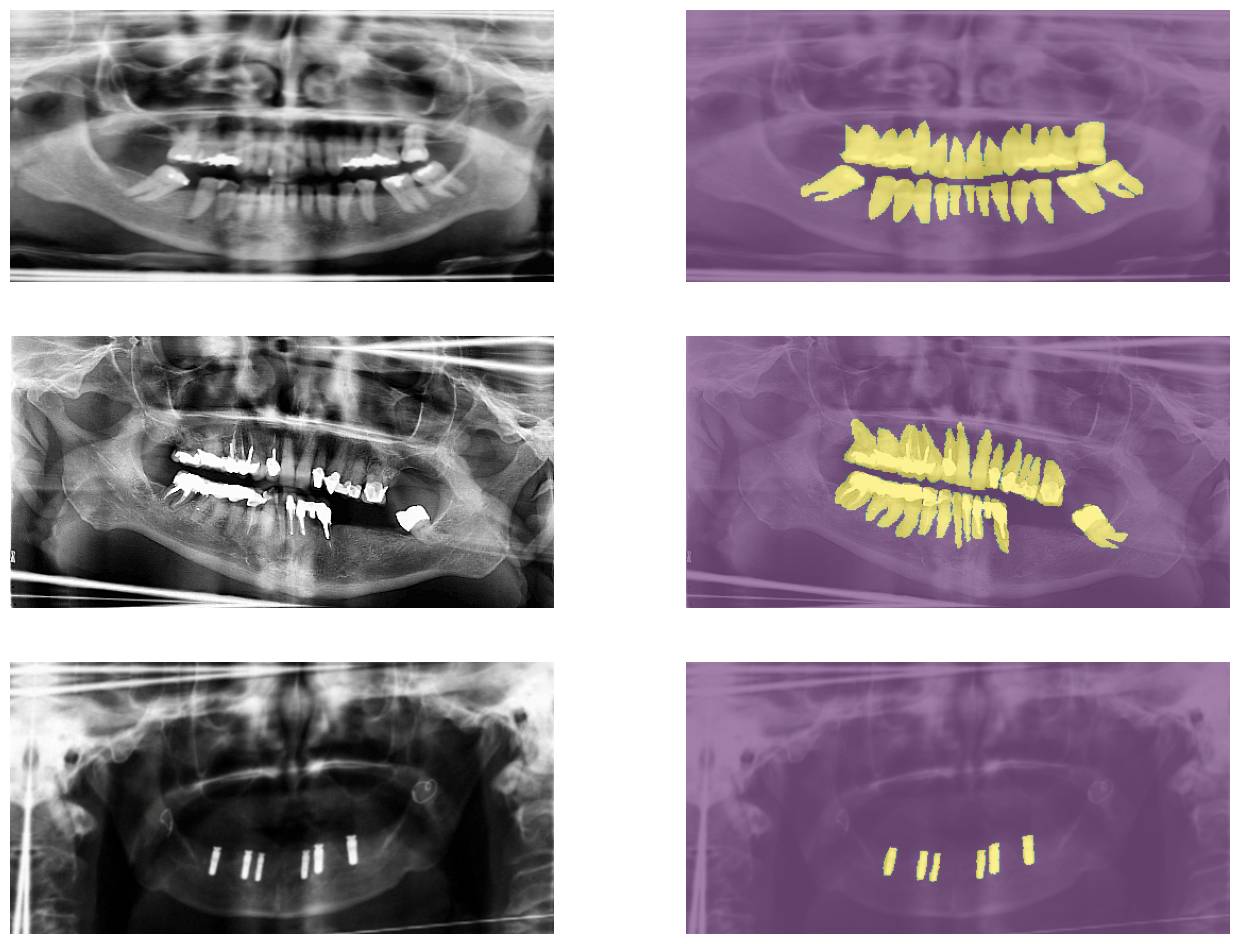

In [ ]:
visualize_batch(train_dataloader, 3)

Change LR, Reduce LROn Plateau

In [18]:
# Function: Import Necessary Libraries
import segmentation as sm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from torchmetrics import JaccardIndex, Accuracy

# Function: Define a PyTorch Lightning Model for Dental Image Segmentation
class DentalModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        # Initialize the model architecture and loss function
        super().__init__()
        self.model = sm.create_model(
            arch=arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs
        )

        self.loss_fn = sm.losses.DiceLoss(sm.losses.BINARY_MODE, from_logits=True)

        # Initialize metrics for evaluation
        self.iou = JaccardIndex(task='binary') # IoU
        self.accuracy = Accuracy(task='binary') # Pixel Accuracy

    def forward(self, x):
        # Forward pass through the model
        return self.model(x)

    def _common_step(self, batch):
        # Common step for training, validation, and testing
        image, mask = batch
        assert image.ndim ==4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        loss = self.loss_fn(logits_mask, mask)

        return loss, logits_mask

    def _calc_metrics(self, loss, logits_mask, target_mask, stage):
        # Calculate metrics for evaluation
        dice = 1.0 - loss

        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        iou = self.iou(pred_mask, target_mask)
        acc = self.accuracy(pred_mask, target_mask)

        if stage == 'val':
            self.logger.experiment.add_scalars('dice', {stage: dice}, self.current_epoch)
            self.logger.experiment.add_scalars('iou', {stage: iou}, self.current_epoch)
            self.logger.experiment.add_scalars('accuracy', {stage: acc}, self.current_epoch)


        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        self.log_dict({
            f'{stage}_dice': dice,
            f'{stage}_iou': iou,
            f'{stage}_acc': acc
        }, on_step=False, on_epoch=True)


    def training_step(self, batch, batch_idx):
        # Training step
        loss, _ = self._common_step(batch)
        self.logger.experiment.add_scalars('loss', {'train': loss}, self.current_epoch)
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        # Validation step
        _, target_mask = batch
        loss, logits_mask = self._common_step(batch)
        self.logger.experiment.add_scalars('loss', {'val': loss}, self.current_epoch)
        self._calc_metrics(loss, logits_mask, target_mask, "val")
        return loss

    def test_step(self, batch, batch_idx):
        # Testing step
        _, target_mask = batch
        loss, logits_mask = self._common_step(batch)
        self._calc_metrics(loss, logits_mask, target_mask, "test")
        return loss


    def configure_optimizers(self):
        # Configure optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
        plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': plateau_scheduler, 
                'monitor': 'val_loss'  
            }
        }

# Function: Define Callbacks for Model Training
checkpoint_cb = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    filename='best_checkpoint',
    verbose=True
)

early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=True
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [19]:

import time
from pytorch_lightning.callbacks import Callback

class TrainingTimeLogger(Callback):
    def on_train_start(self, trainer, pl_module):
        self.train_start_time = time.time()
        print("Training started.")

    def on_train_end(self, trainer, pl_module):
        self.train_end_time = time.time()
        elapsed_time = self.train_end_time - self.train_start_time
        print(f"Training finished. Elapsed time: {elapsed_time:.2f} seconds")

# Logs the training time of a model

In [20]:
model = DentalModel("unet", "resnet34", in_channels=3, out_classes=1)

Using Epoch 250

In [22]:
from pytorch_lightning.loggers import TensorBoardLogger

tensorboard_logger = TensorBoardLogger("/content/drive/MyDrive/Dataset_TUFT_Dental/Experiment_Result", name="unet-resnet34_bs32_ch_param")
time_logger = TrainingTimeLogger()

#TensorBoard Logger and Training Time Logger Initialization

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=250,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_monitor, time_logger],
    logger=tensorboard_logger
)

#PyTorch Lightning Trainer Initialization

#Model Training
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/drive/MyDrive/Dataset_TUFT_Dental/Experiment_Result/unet-resnet34_bs32_ch_param/version_1/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | Unet               | 24.4 M
1 | loss_fn  | DiceLoss           | 0     
2 | iou      | BinaryJaccardIndex | 0     
3 | accuracy | BinaryAccuracy     | 0     
-------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training started.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 21 records. Best score: 0.088. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 22: 'val_loss' was not in top 1


Training finished. Elapsed time: 16.60 seconds


In [23]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 0.11937299370765686, 'test_dice': 0.880626916885376, 'test_iou': 0.7878338694572449, 'test_acc': 0.9722816944122314}]


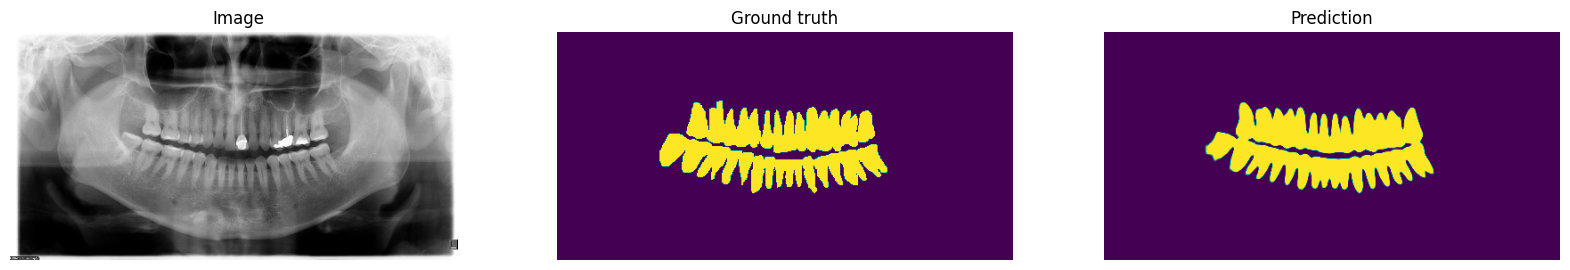

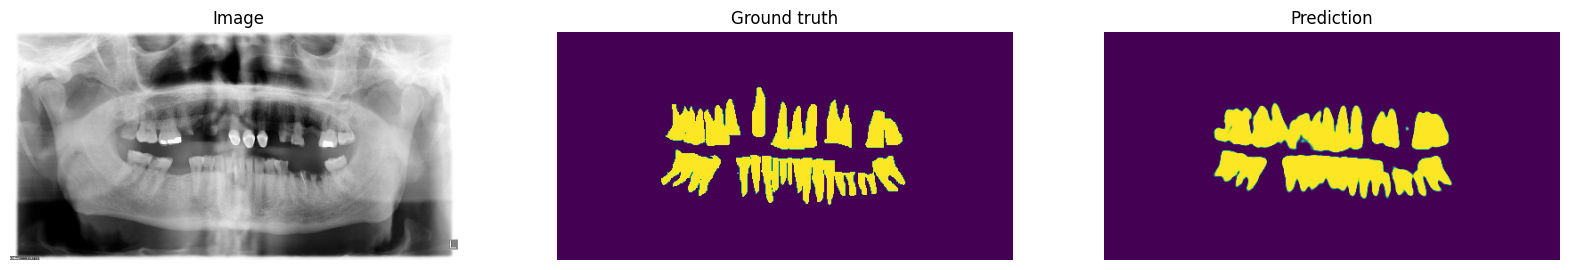

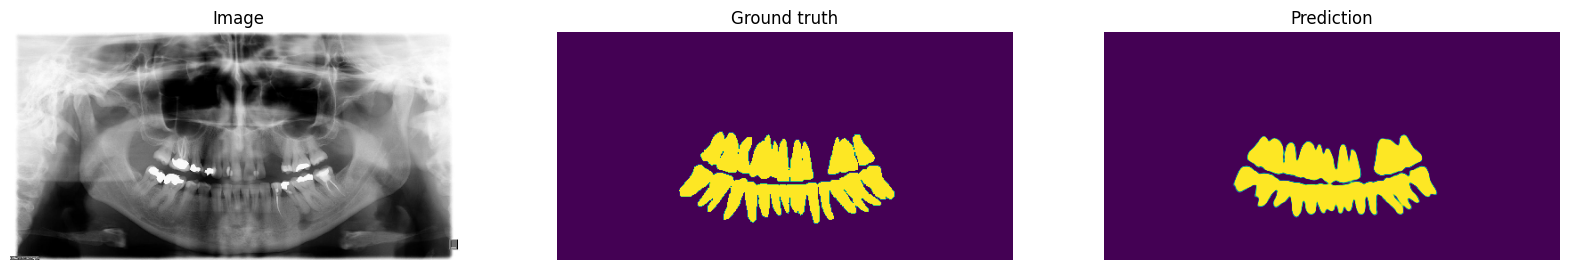

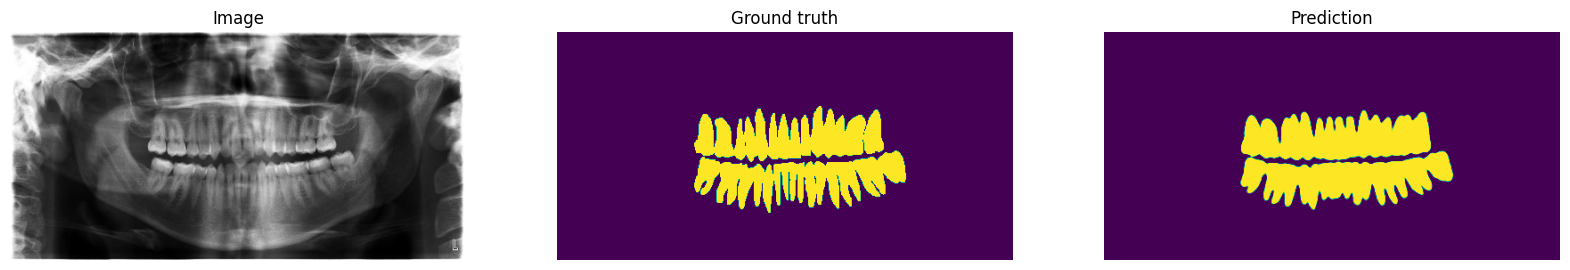

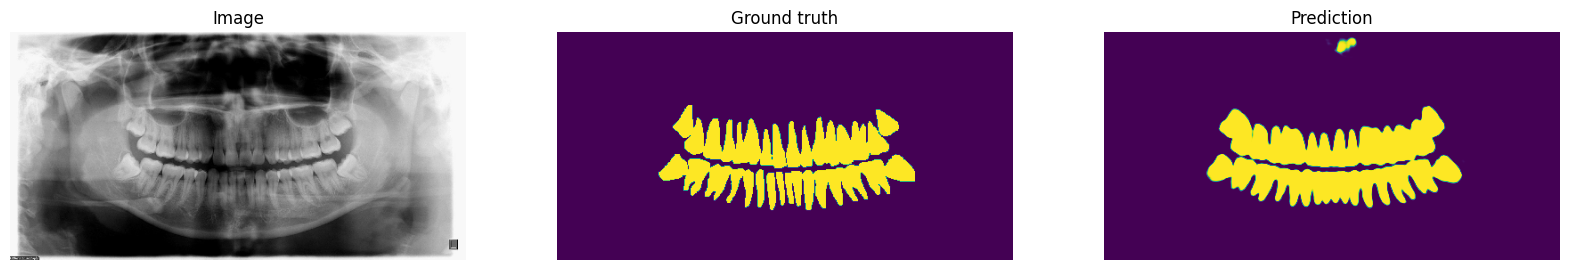

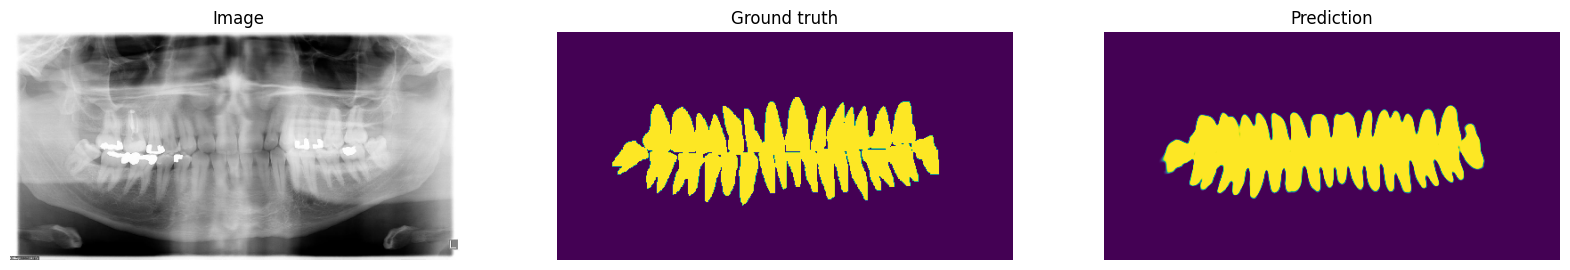

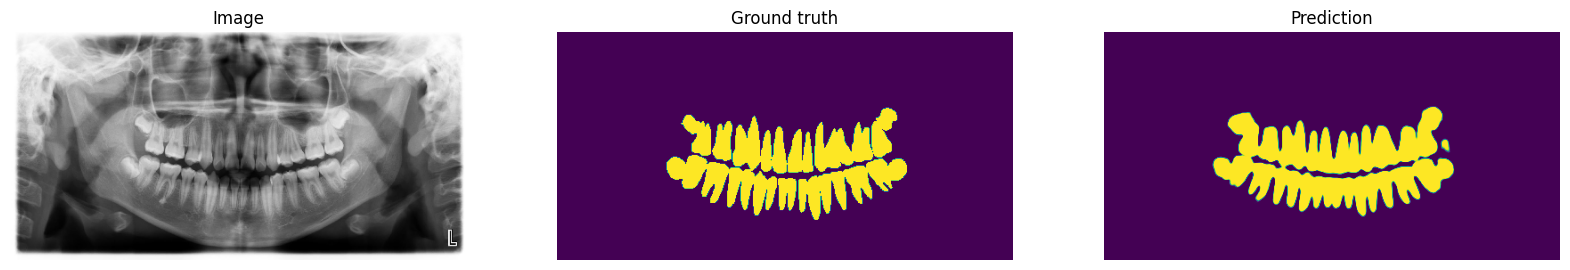

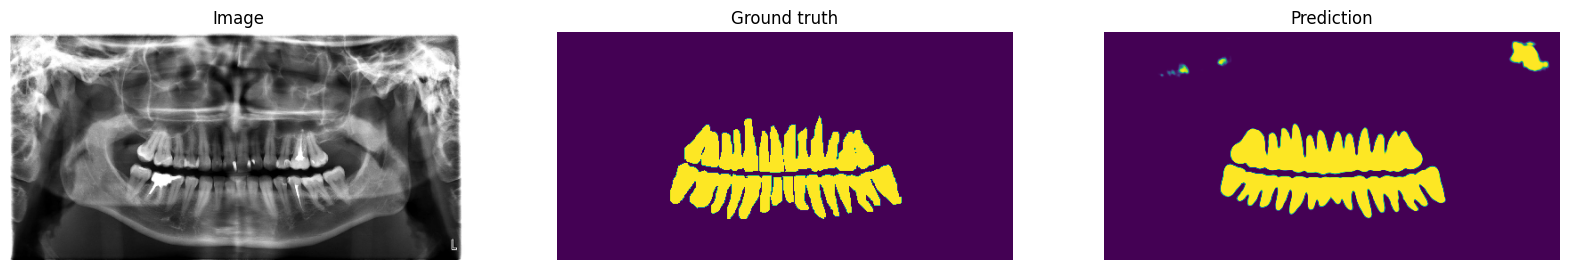

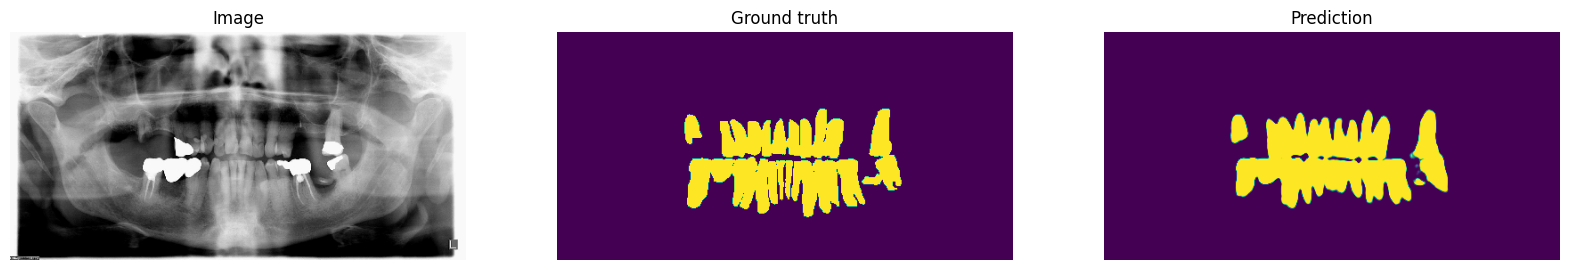

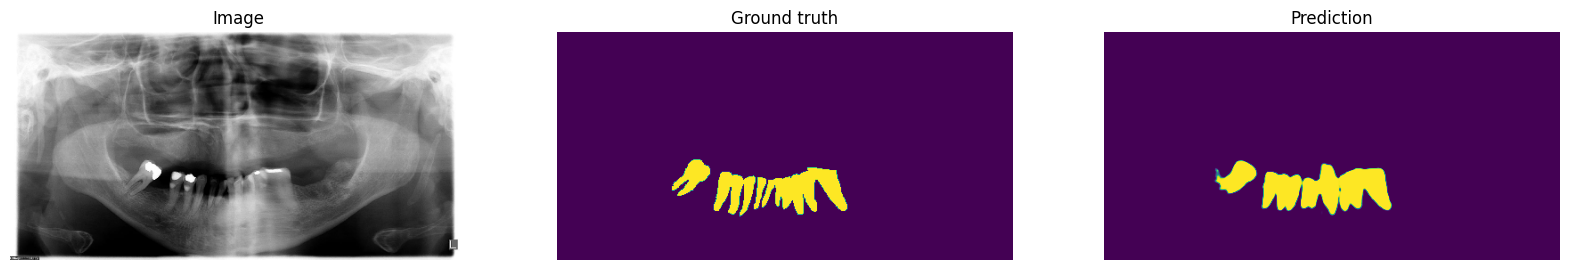

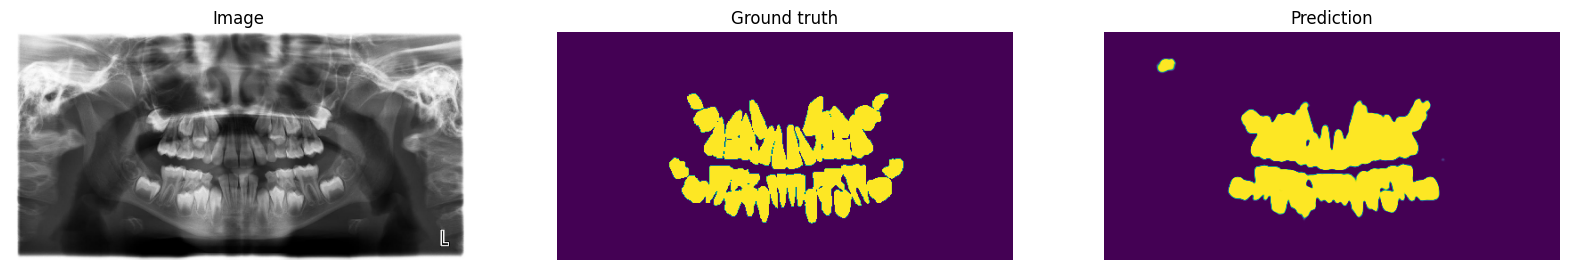

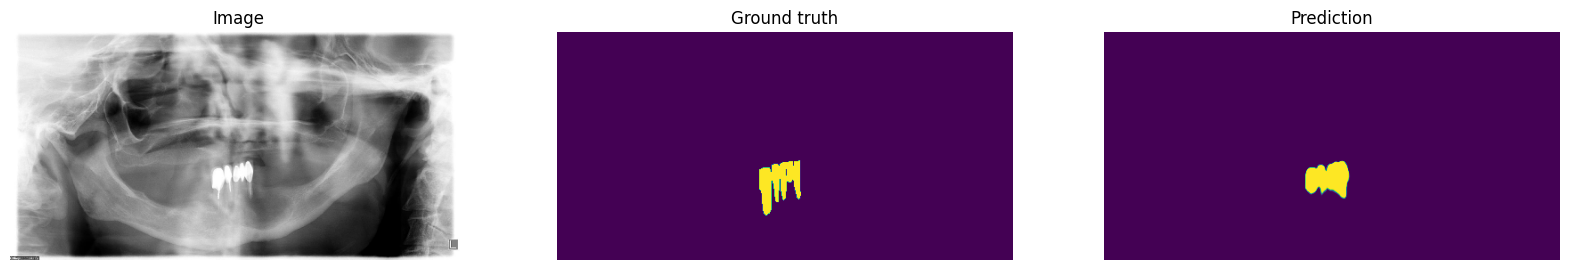

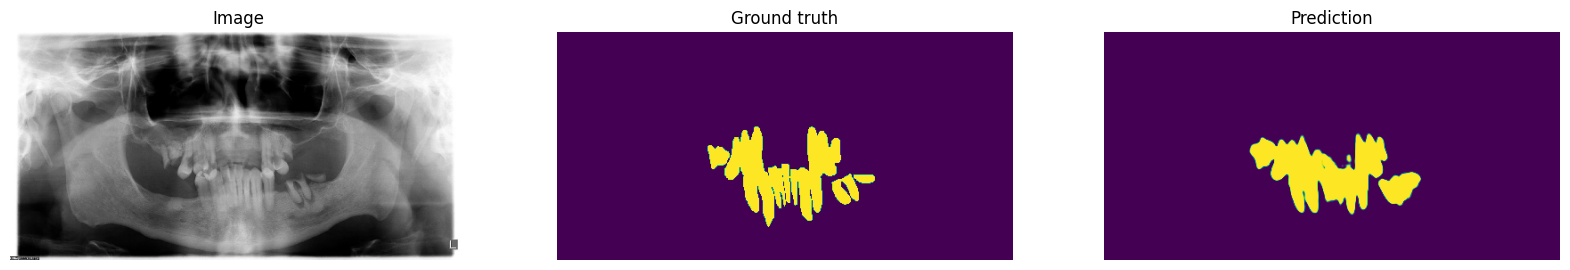

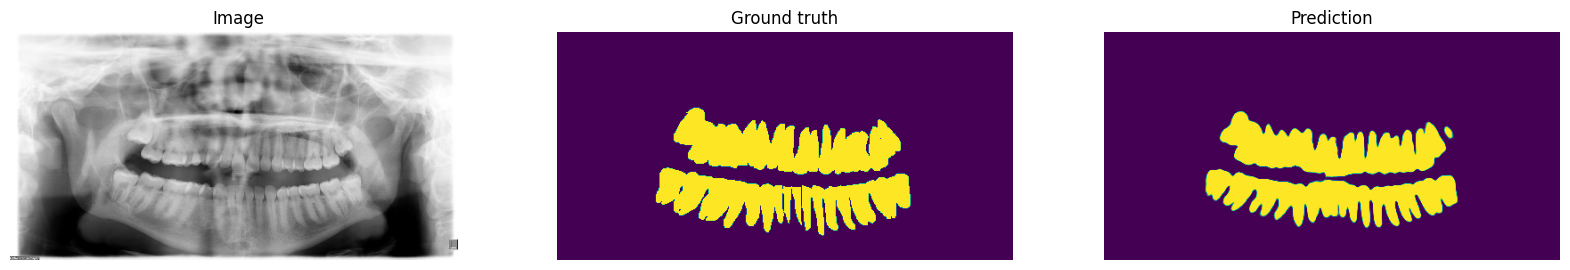

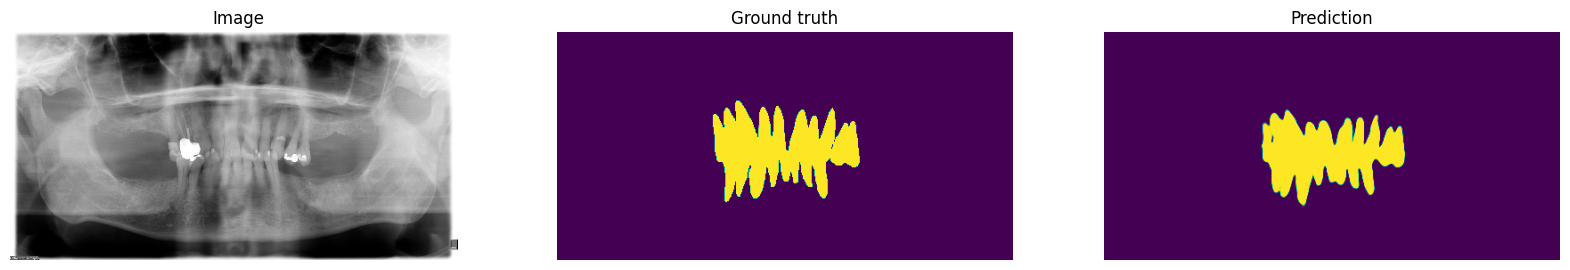

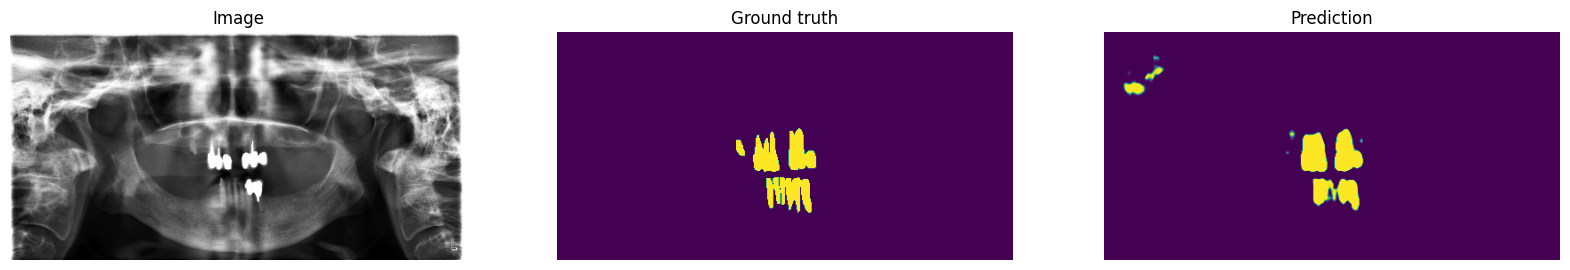

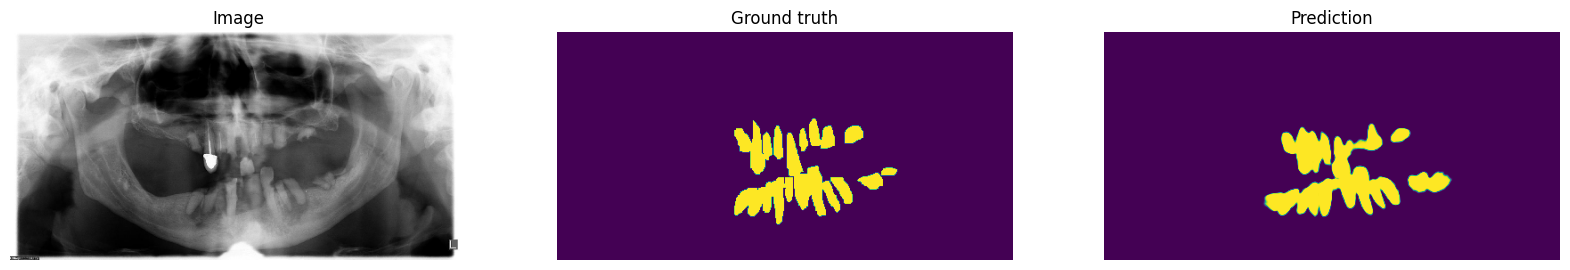

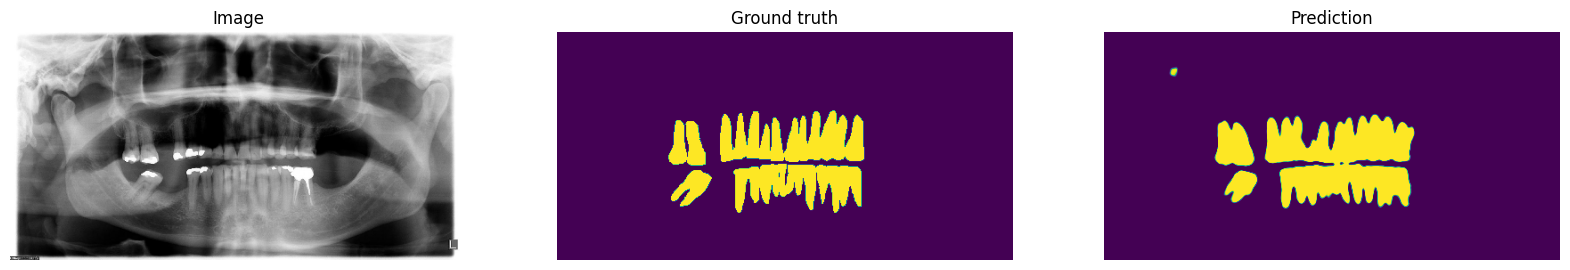

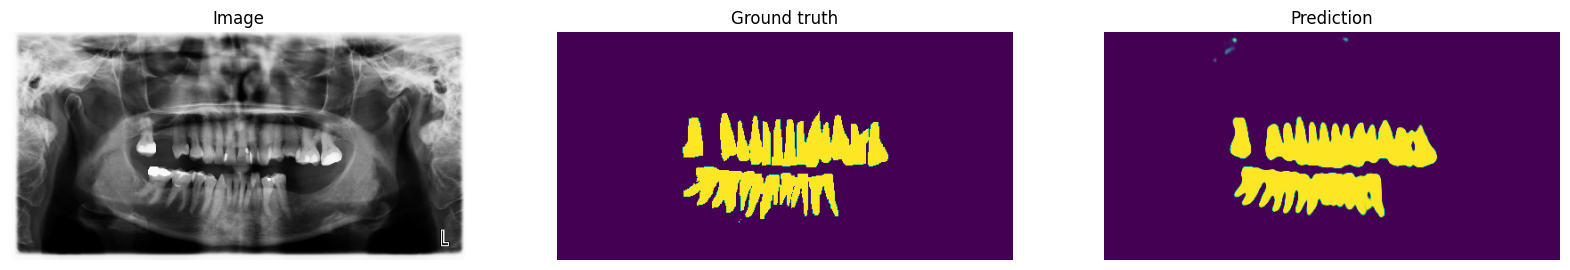

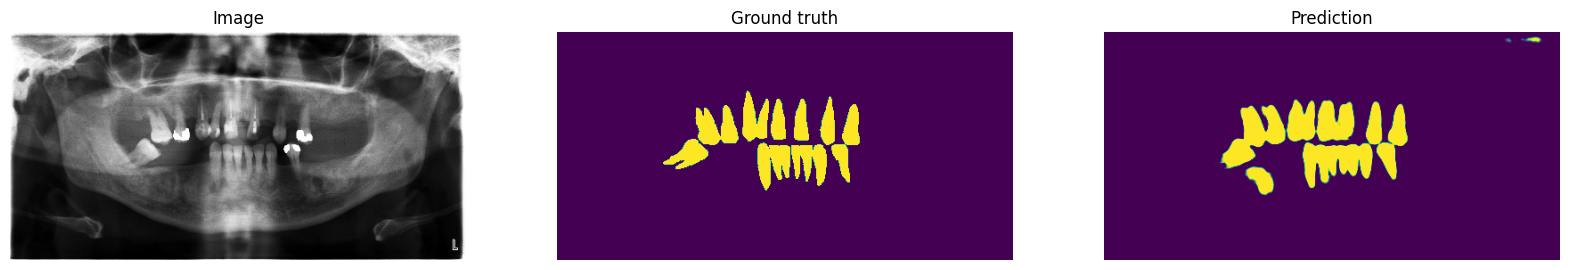

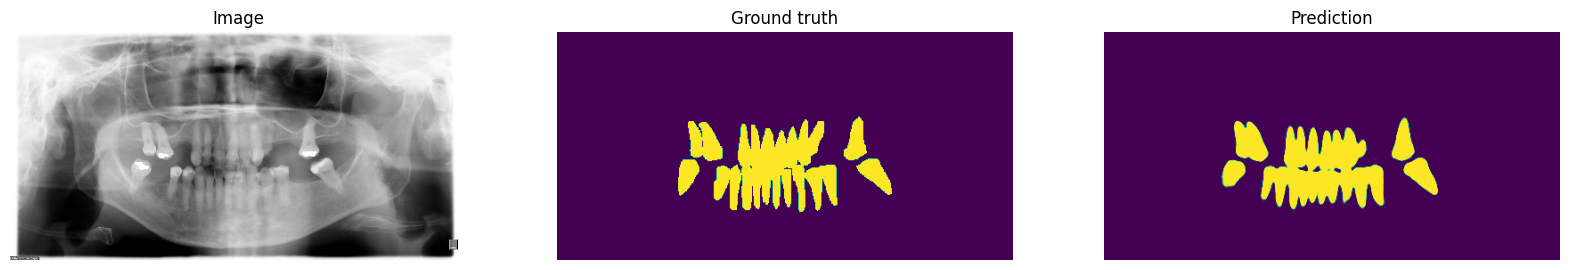

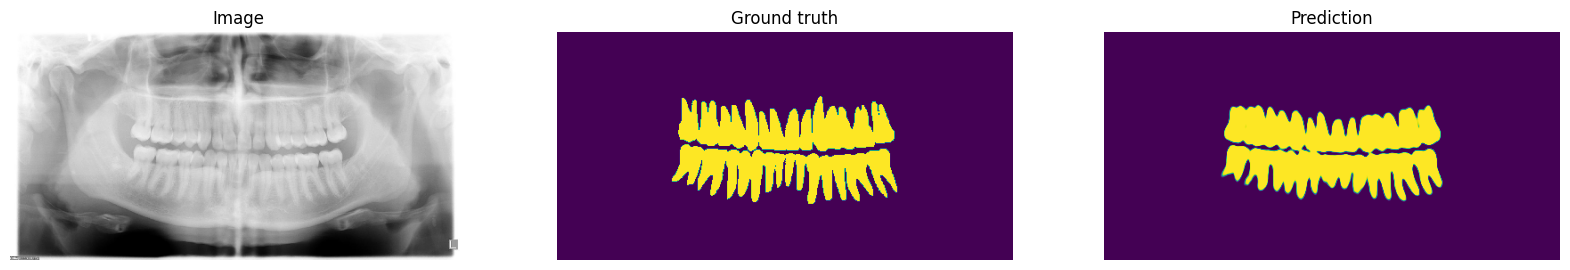

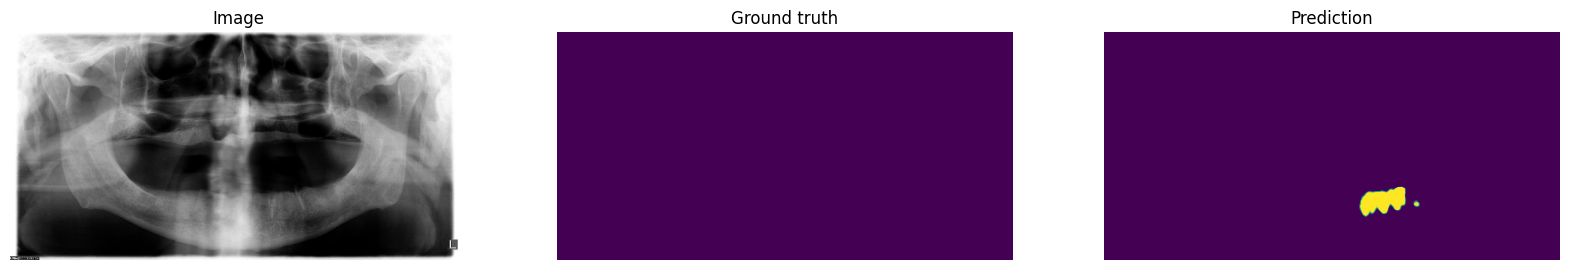

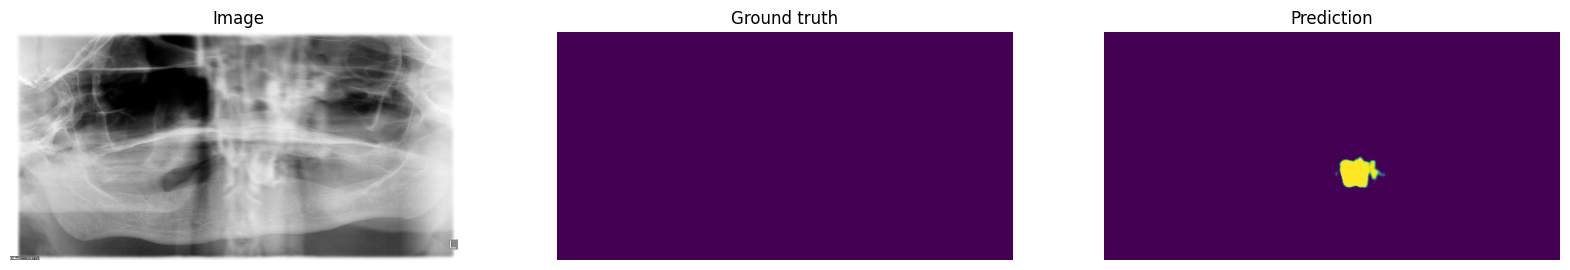

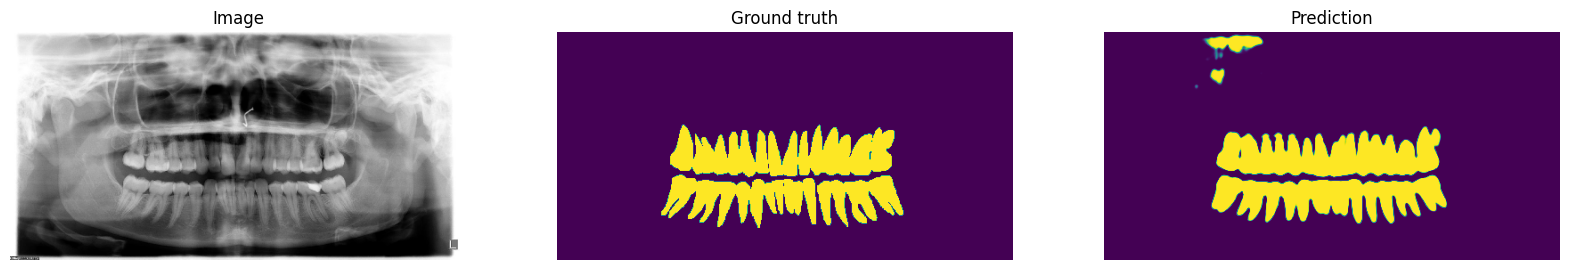

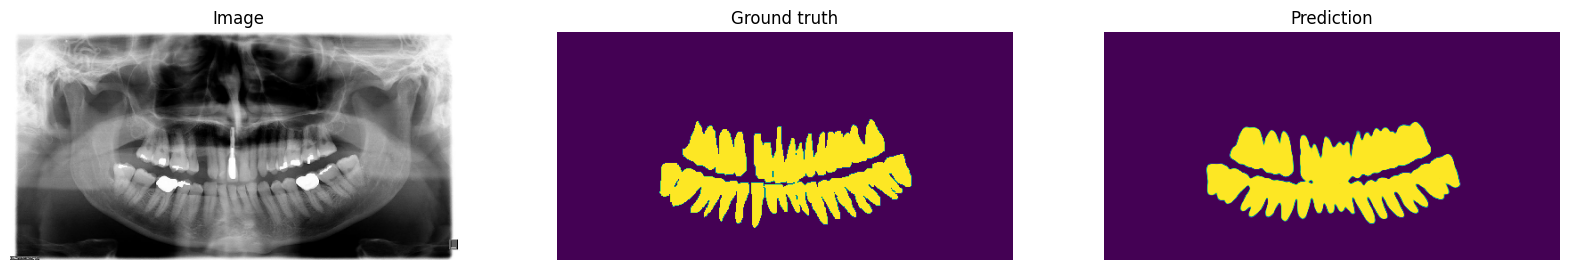

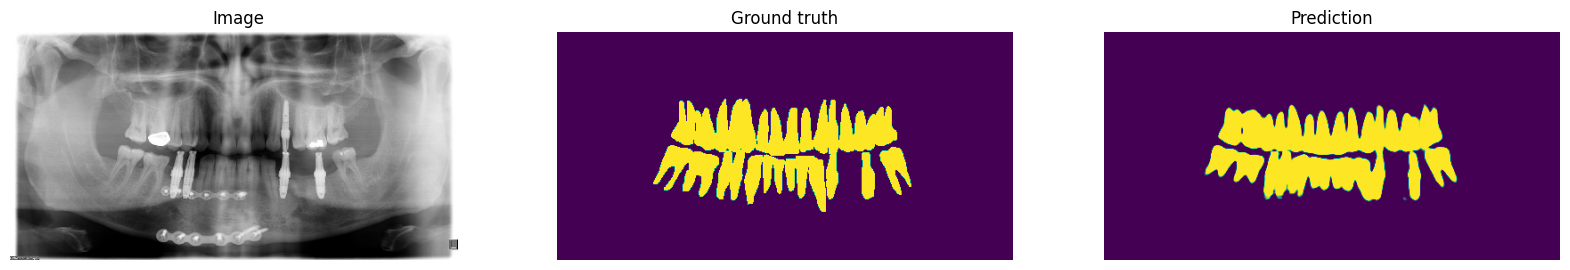

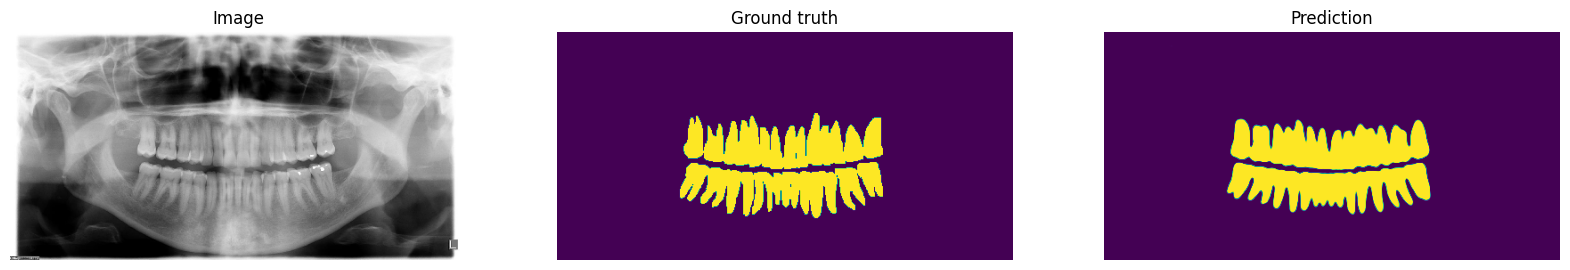

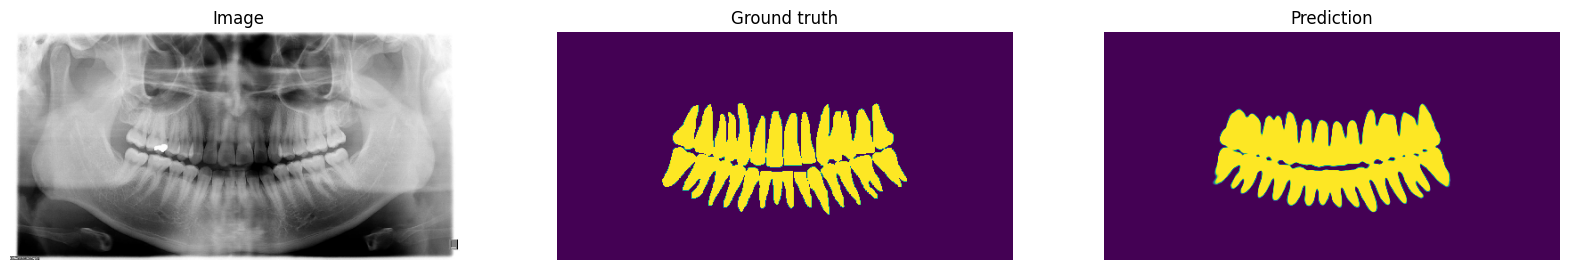

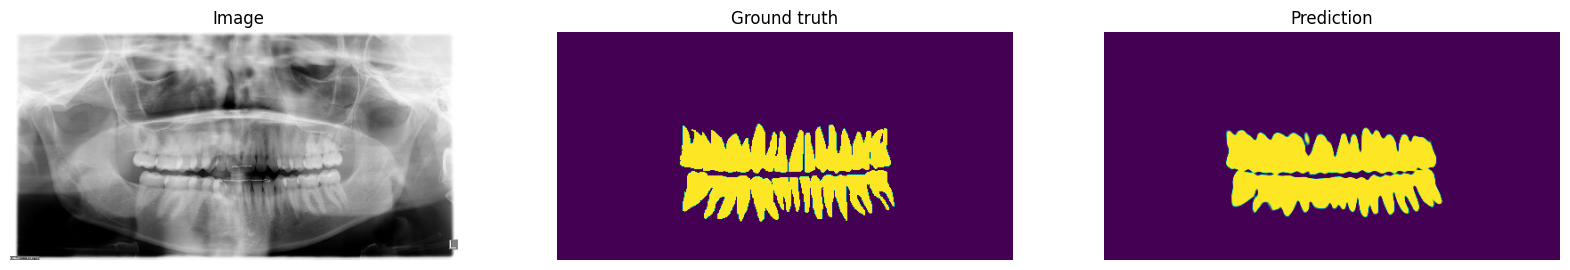

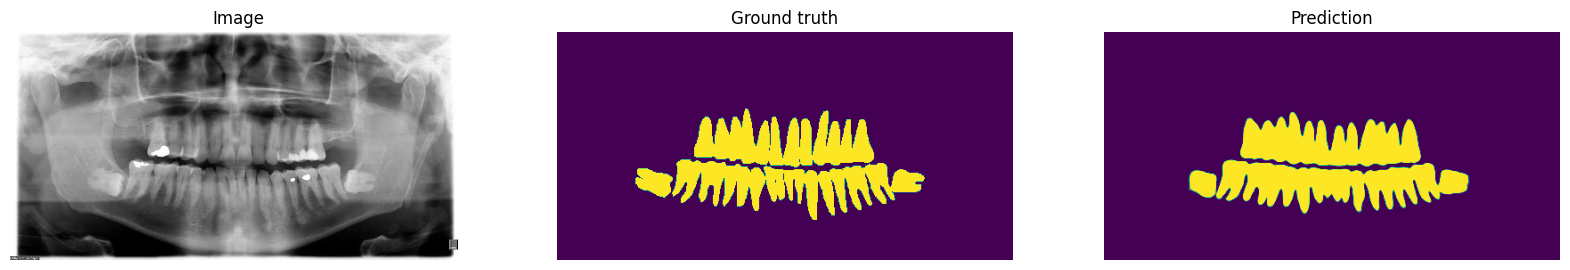

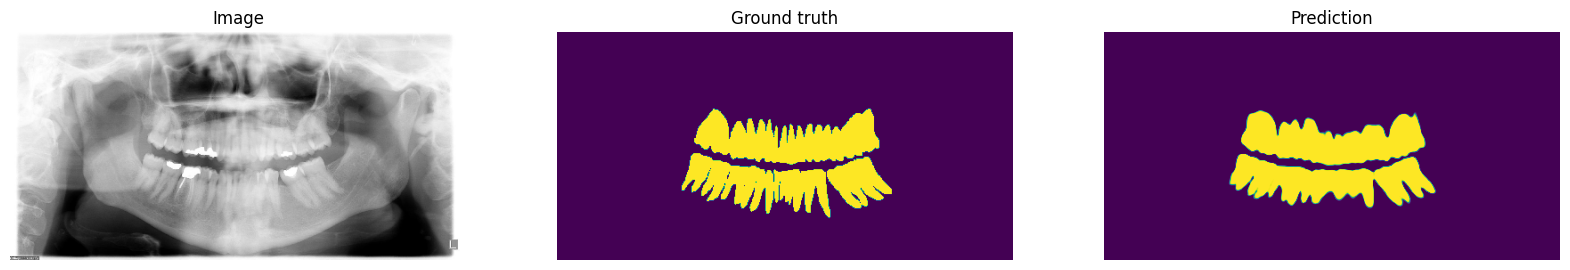

In [24]:
batch = next(iter(test_dataloader))


image, mask = batch

with torch.inference_mode():
    model.eval()
    logits = model(image)
pr_masks = logits.sigmoid()


for image, gt_mask, pr_mask in zip(image, mask, pr_masks):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [ ]:
# Disconnect the Colab session after training
import time
time.sleep(5)  # Give some time to save any necessary checkpoints
from google.colab import runtime
runtime.unassign()